# First Model for New Data

August 22, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5' #'data/cloud_data_stim_dim80_robs_sqrad_0.1.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
L4_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))
print('L4 cells:', len(L4_idx))

LGN cells: 214
V1 cells: 1491
L4 cells: 794


In [4]:
V1_cell_key = [cell_key[i] for i in V1_idx]
L23_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L2/3']
L23_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L2/3']
L4_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L4']
L4_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L4']

## Data Class

In [4]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=L4_idx, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 50.12999701499939 sec


In [5]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60


In [6]:
NC = data[0]['robs'].shape[1]
print('Number of cells', NC)

Number of cells 794


In [7]:
NT = data.NT
print('Number of time points', NT)

Number of time points 510000


In [8]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[L4_idx], y_pos[L4_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (794, 2)


In [9]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=3,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulated_grad_batches=3)
adam_pars['device'] = device

## STA

In [11]:
robs = data[:]['robs'][:,:10]*data[:]['dfs'][:,:10]
nspks = torch.sum(robs,axis=0)

In [13]:
sta_arr = np.zeros((4,L,L,10))
for j in range(4):
    if j == 0:
        sta = (data[:]['stim'].T @ robs)
    else:
        sta = (data[:]['stim'][:-j, ...].T @ robs[j:,:])
    sta_arr[j,:,:,:] = (sta/nspks).reshape([L,L,10]).numpy() #.detach().cpu().numpy()

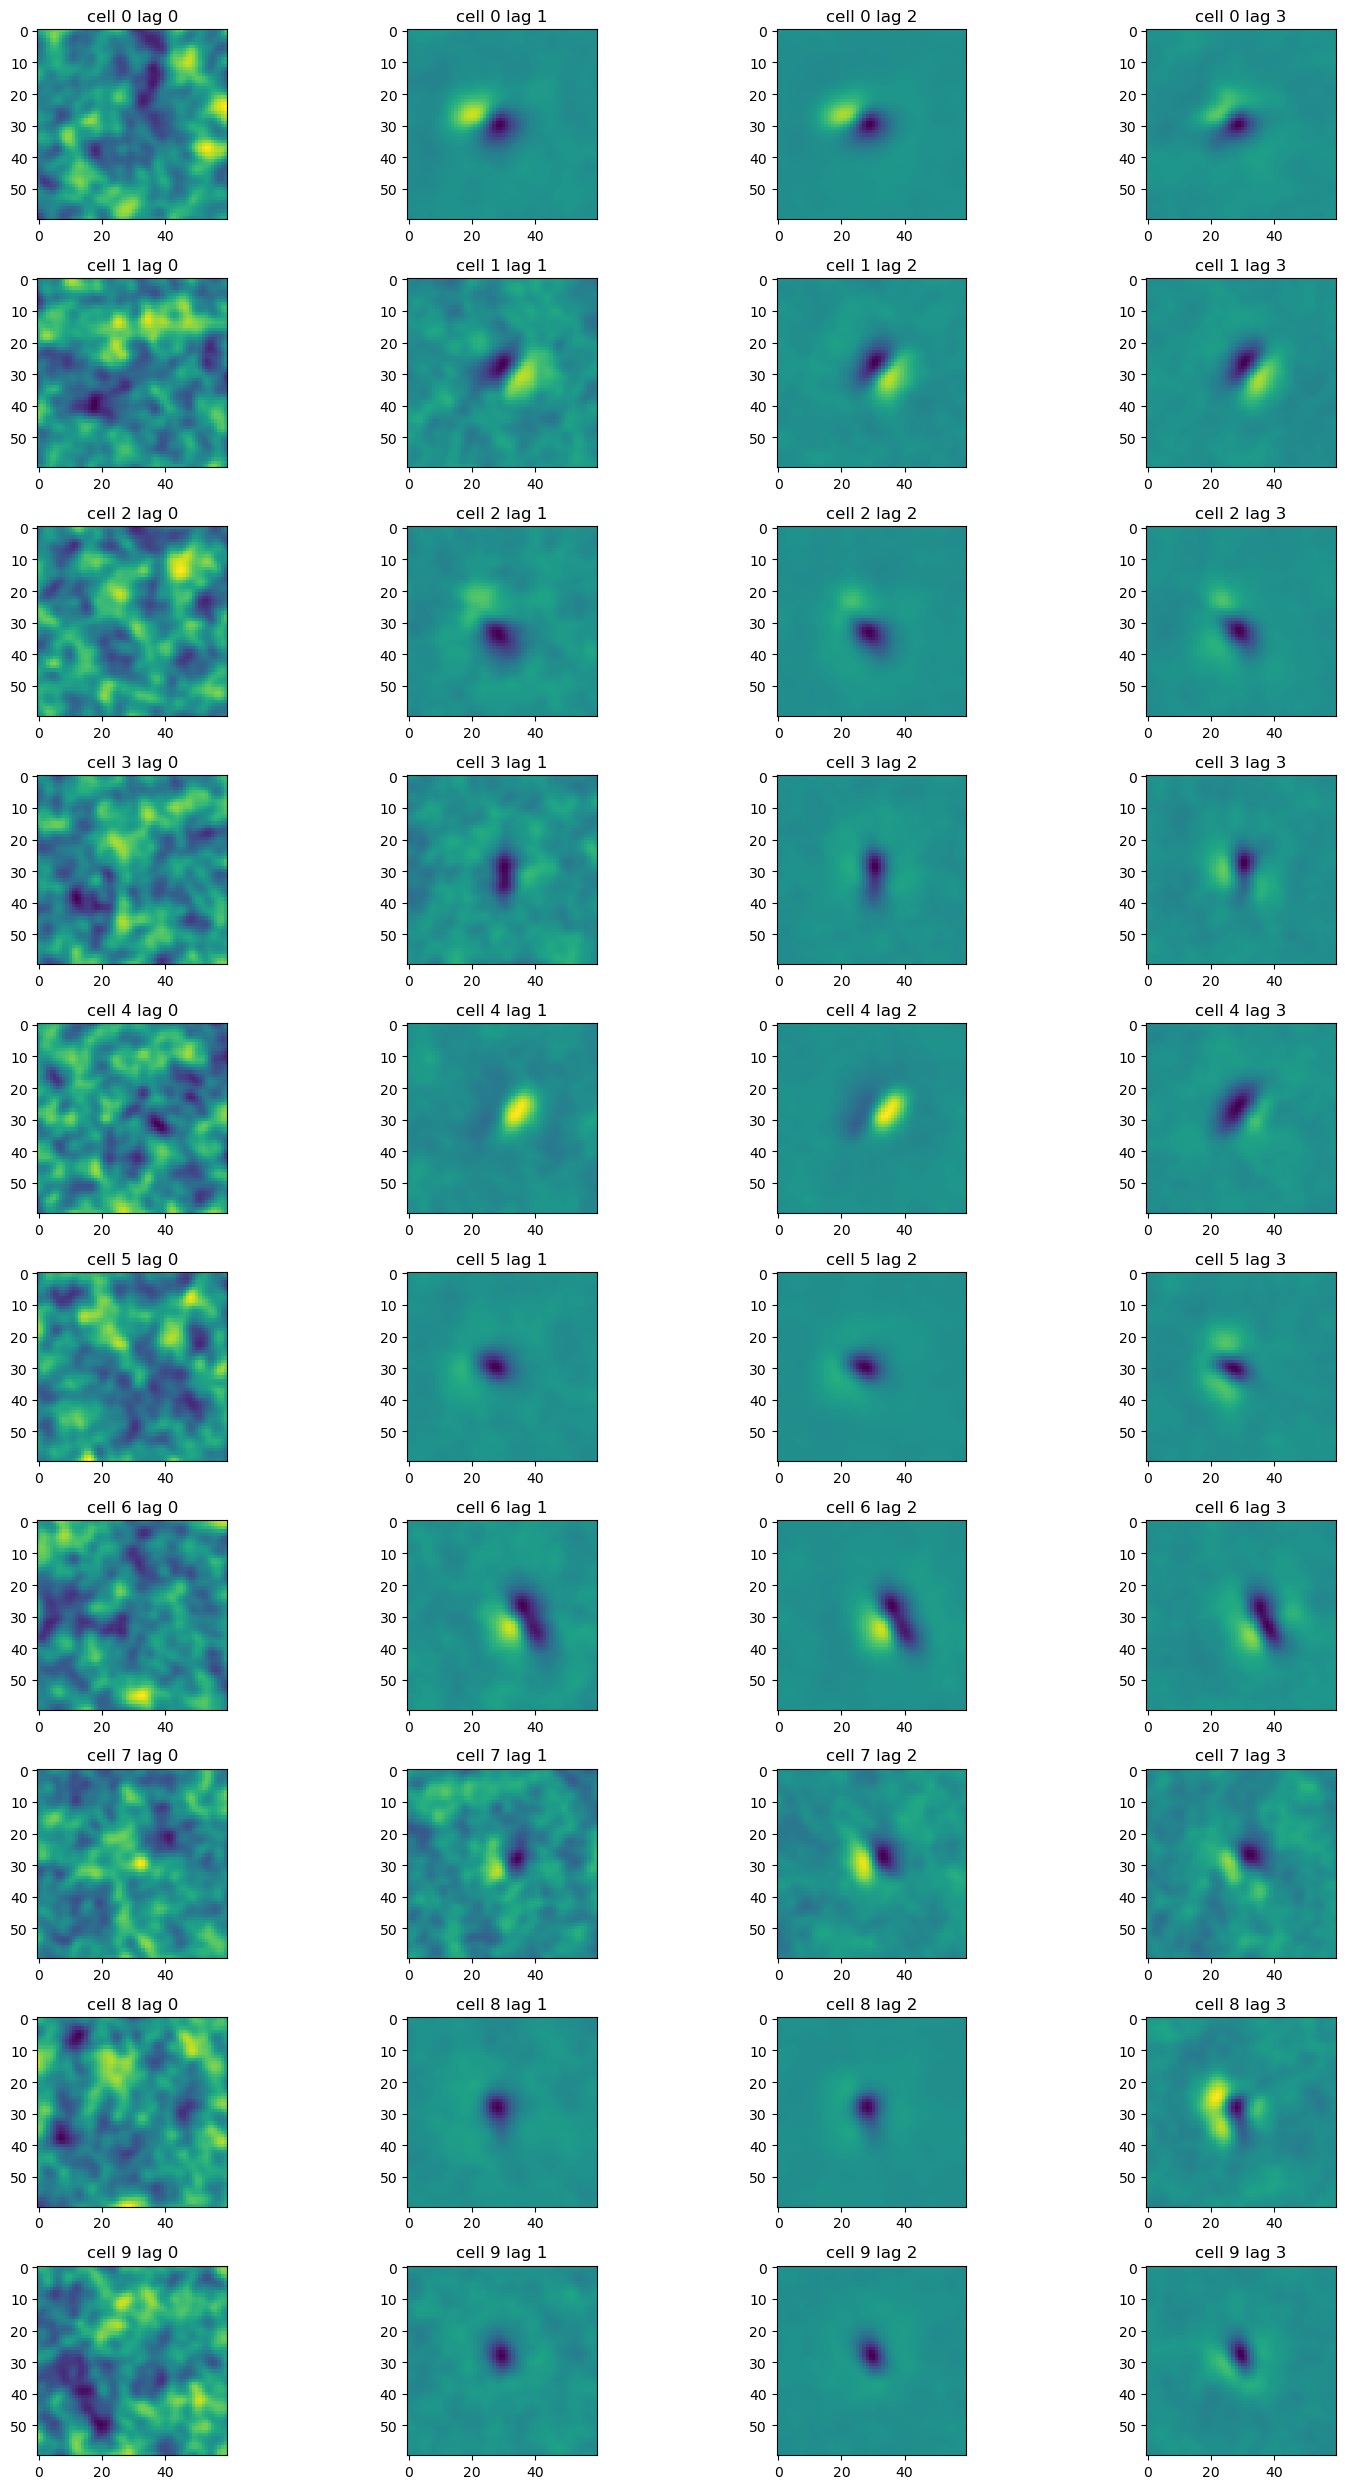

In [14]:
cc = 10
ss(cc,4)
k = 1
for i in range(cc):
    for j in range(4):
        plt.subplot(cc,4,k)
        imagesc(sta_arr[j,:,:,i])
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

In [33]:
# TO DO: change to pixle space
V1_y_pos = (x_pos[V1_idx]*10)+L//2
V1_x_pos = -1*((y_pos[V1_idx]*10)+L//2)+L
V1_ori   = ori[V1_idx]

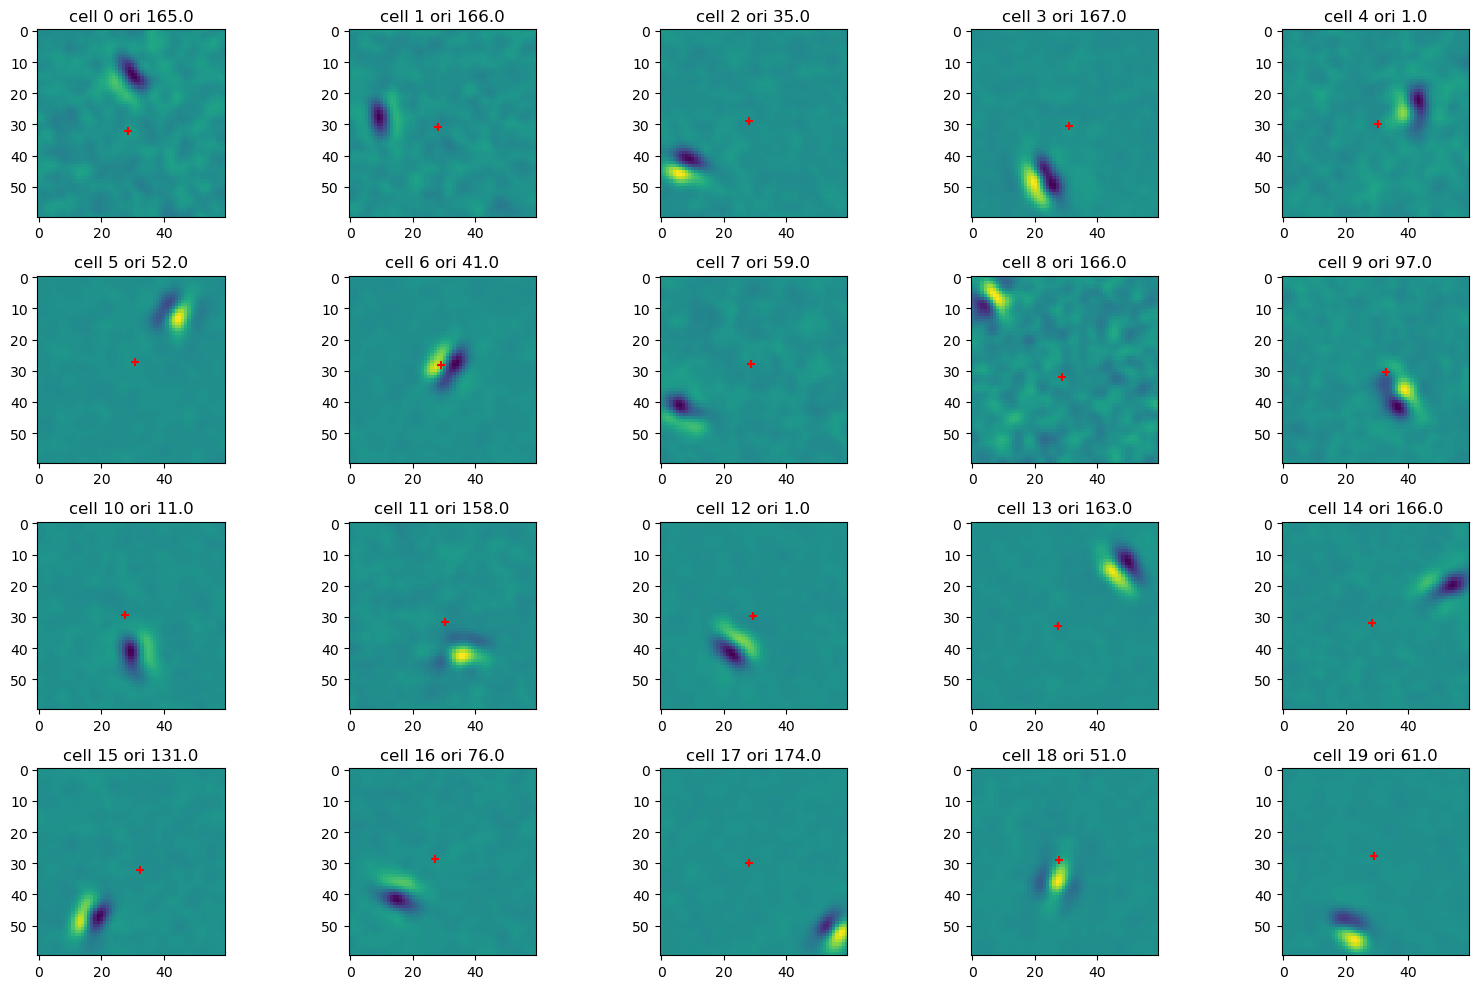

In [34]:
ss(4,5)
k = 1
for i in range(20):
    plt.subplot(4,5,i+1)
    imagesc(sta_arr[2,:,:,i])
    plt.scatter(V1_x_pos[i],V1_y_pos[i],c='r',s=40,marker='+')
    plt.title('cell '+str(i)+' ori '+str(np.round((180/np.pi)*V1_ori[i])))
plt.tight_layout()

## GLM

In [13]:
Treg = 1
Xreg = 10000.0
L1reg = 1.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=NC, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 

glm = NDN( layer_list=[glm_par], loss_type='poisson')
glm.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([43200, 10])
      bias: torch.Size([10])


In [14]:
glm = glm.to(device)
fit_lbfgs(glm, data[:], verbose=True)
glm = glm.to(device0)

Iteration: 0 | Loss: 0.8419547080993652
Iteration: 1 | Loss: 0.8403301239013672
Iteration: 1 | Loss: 0.8261598348617554
Iteration: 1 | Loss: 0.7287380695343018
Iteration: 2 | Loss: 0.6762744188308716
Iteration: 3 | Loss: 0.6464005708694458
Iteration: 4 | Loss: 0.6242513656616211
Iteration: 5 | Loss: 0.5371630191802979
Iteration: 6 | Loss: 0.4623411297798157
Iteration: 7 | Loss: 0.3711909055709839
Iteration: 8 | Loss: 0.29766950011253357
Iteration: 9 | Loss: 0.252692312002182
Iteration: 10 | Loss: 0.23307548463344574
Iteration: 11 | Loss: 0.22345924377441406
Iteration: 12 | Loss: 0.21627582609653473
Iteration: 13 | Loss: 0.21284550428390503
Iteration: 14 | Loss: 0.21095038950443268
Iteration: 15 | Loss: 0.21007248759269714
Iteration: 16 | Loss: 0.2093385010957718
Iteration: 17 | Loss: 0.2088860720396042
Iteration: 18 | Loss: 0.2084401249885559
Iteration: 19 | Loss: 0.20813417434692383
Iteration: 20 | Loss: 0.20780596137046814
Iteration: 21 | Loss: 0.20740480720996857
Iteration: 22 | Los

In [15]:
w_glm = glm.get_weights()
print(w_glm.shape)

(60, 60, 12, 10)


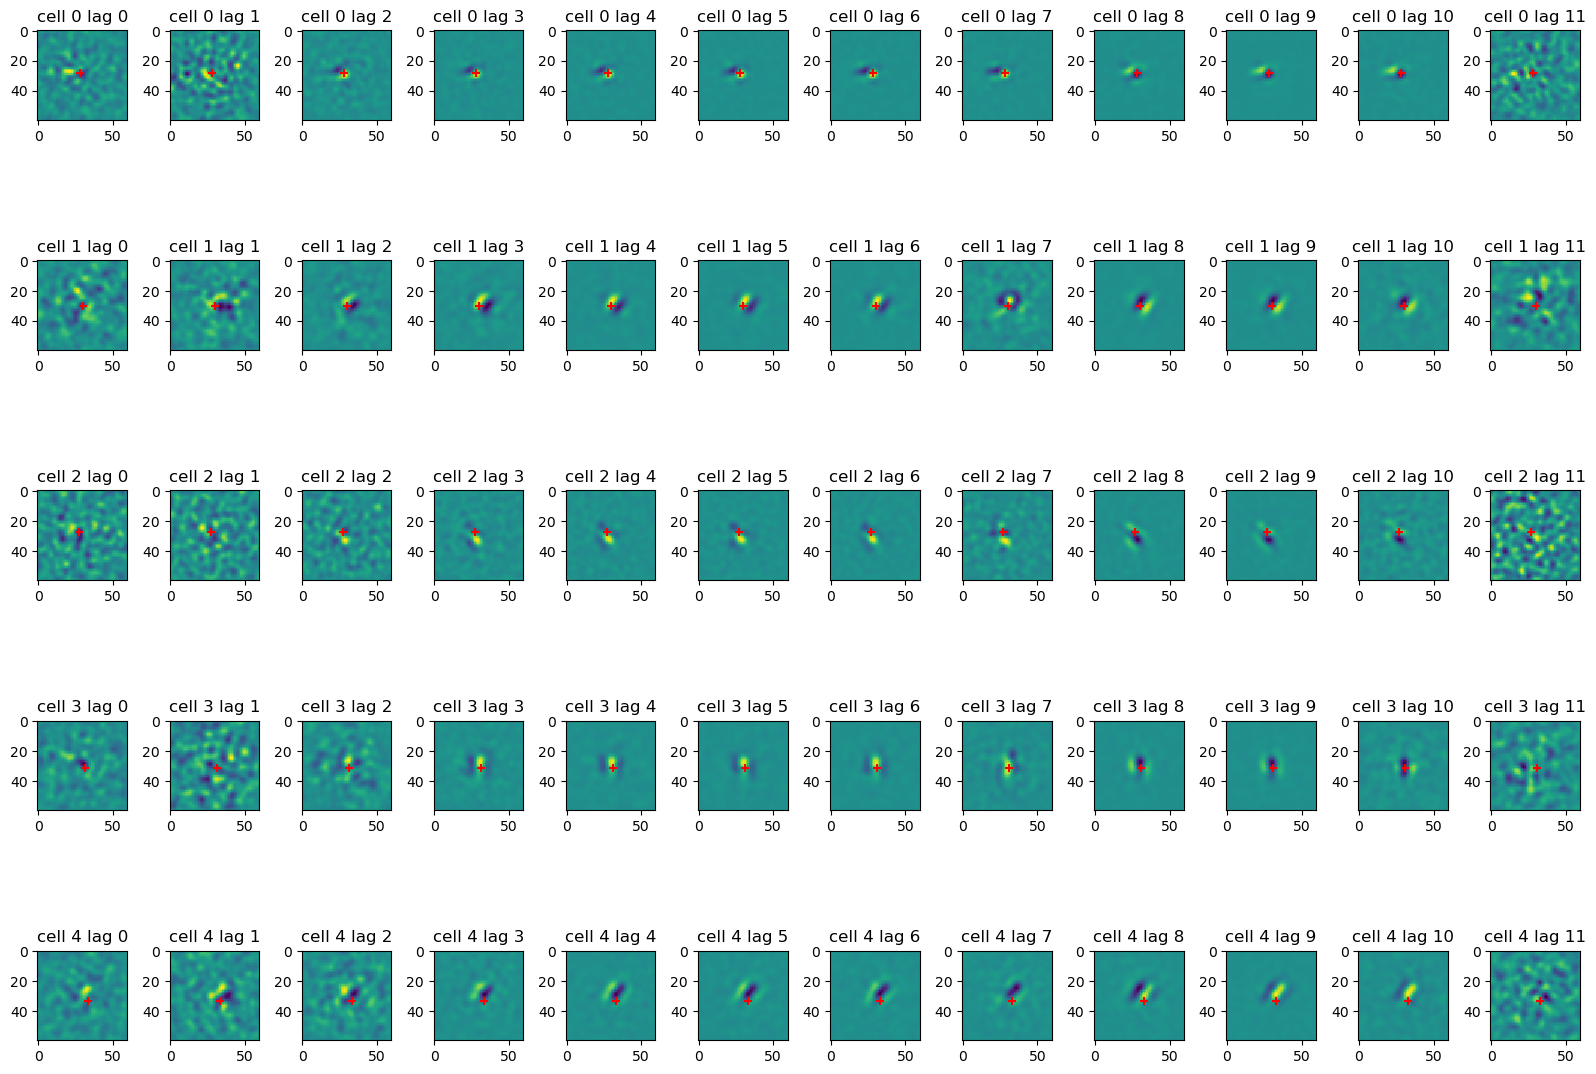

In [22]:
ss(5,12)
k = 1
for i in range(5):
    for j in range(12):
        plt.subplot(5,12,k)
        imagesc(w_glm[:,:,j,i])
        plt.scatter(pxl_x_pos[V1_idx][i],pxl_x_pos[V1_idx][i],c='r',s=40,marker='+')
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

## Ori CNN

In [25]:
# LGN layer reg
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center
Treg = 1
#LGNwidth = LGN_filt.shape[0]

# Proj layer — still playing around with these
Xreg1 = 0.001 # d2/dx
Creg1 = 0.001 # center

ORIreg = 0 # chose orientation over spacial dim

# Define convolutional layers in the deep network
num_subs = [8,8,8] # num sub-units per layer
fws = [19,9,9]  # filter widths for each layer 
angles = [0,30,60,90,120,150] # [0,45,90,135]

# LGN layer
clayers = [STconvLayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=2, bias=False, norm_type=1, 
    filter_dims=[1,19,19,num_lags], NLtype='relu', initialize_center=True,
    reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg0, 'center': Creg0} )]

# Projection Layer
clayers.append(OriConvLayer.layer_dict(
    num_filters=num_subs[0], num_inh=num_subs[0]//4,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_width=fws[0], NLtype='relu', reg_vals={'d2x':Xreg1, 'center': Creg1},
    angles=angles))

# Rest
for ii in range(1,len(fws)):
    clayers.append(OriConvLayer.layer_dict( 
        num_filters=num_subs[ii], num_inh=num_subs[ii]//4, bias=False, norm_type=1, 
        filter_width=fws[ii], NLtype='relu',
        output_norm='batch', initialize_center=True, #window='hamming', 
        angles=angles) )
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayers, scaffold_levels=[1,2,3], num_lags_out=len(angles))

readout_pars = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'gmax_t': None})

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poisson')

#cnn.networks[0].layers[0].weight.data = LGN_filt.reshape((LGNwidth**2,2))  # this it the LGN from before
#cnn.networks[0].layers[0].set_parameters(val=True)

cnn.networks[1].layers[0].mu.data[:,0] = torch.tensor( mu0s[:,0], dtype=torch.float32)
cnn.networks[1].layers[0].mu.data[:,1] = torch.tensor( mu0s[:,1], dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)
cnn.networks[1].layers[0].fit_Qmus(True)

cnn.block_sample = True
cnn.list_parameters()

  ReadoutLayer: fitting mus
  ReadoutLayer: fitting Qmus
Network 0:
  Layer 0:
      weight: torch.Size([4332, 2])
  Layer 1:
      weight: torch.Size([722, 8])
  Layer 2:
      weight: torch.Size([648, 8])
  Layer 3:
      weight: torch.Size([648, 8])
Network 1:
  Layer 0:
      weight: torch.Size([24, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])


In [26]:
#cnn = cnn.to(device)
cnn.fit(data, **adam_pars, verbose=2)
#cnn = cnn.to(device0)

Model: M491_CsXXX_X

GPU Available: True, GPU Used: True


Epoch 11:   7%|███▊                                                  | 29/408 [00:36<08:03,  1.28s/it, train_loss=0.302408]

Done fitting
  Fit complete: 5713.0190143585205 sec elapsed


In [42]:
cnn.save_model_zip('models/0916_four_layer_model.ndn')

  Model saved:  models/0916_four_layer_model.ndn


In [11]:
cnn = NDN.load_model_zip('models/first_model_test_NLL.ndn')
cnn.block_sample = True

In [15]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=2, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  8.72it/s]

Log Likelyhood shape (1491,)


Median LL: 0.38476136


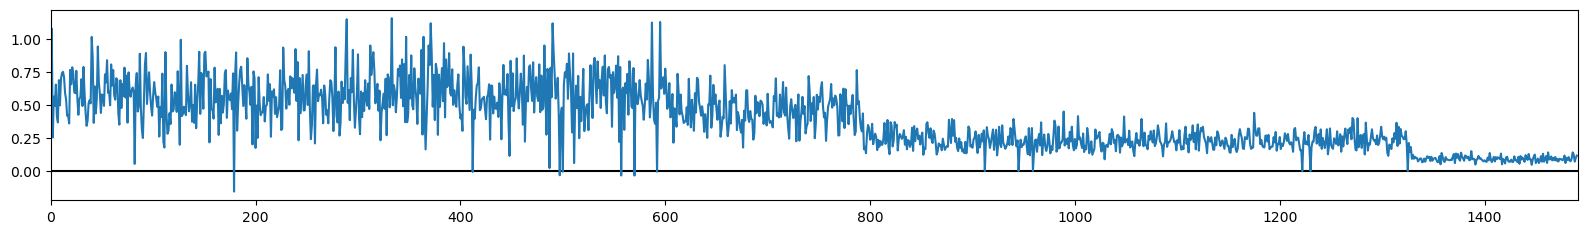

In [43]:
print('Mean LL:', np.mean(LL), 'L23 Exc LL:', np.mean(LL[L23_exc_idx]), 'L23 Inh LL:', np.mean(LL[L23_inh_idx]), 
      'L4 Exc LL:', np.mean(LL[L4_exc_idx]), 'L4 Inh LL:', np.mean(LL[L4_inh_idx]))
ss()
plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.xlim([0,NC])
plt.show()

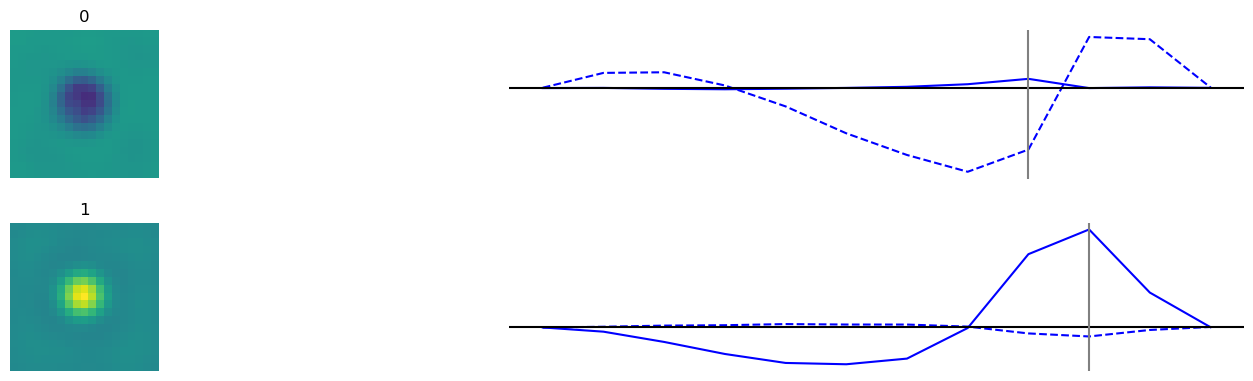

In [29]:
cnn.plot_filters()

In [30]:
ori_filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
ei_mask = deepcopy(cnn.networks[0].layers[1]._ei_mask)
print(ori_filters1.shape)
print(ei_mask.shape)

(2, 19, 19, 8)
torch.Size([48])


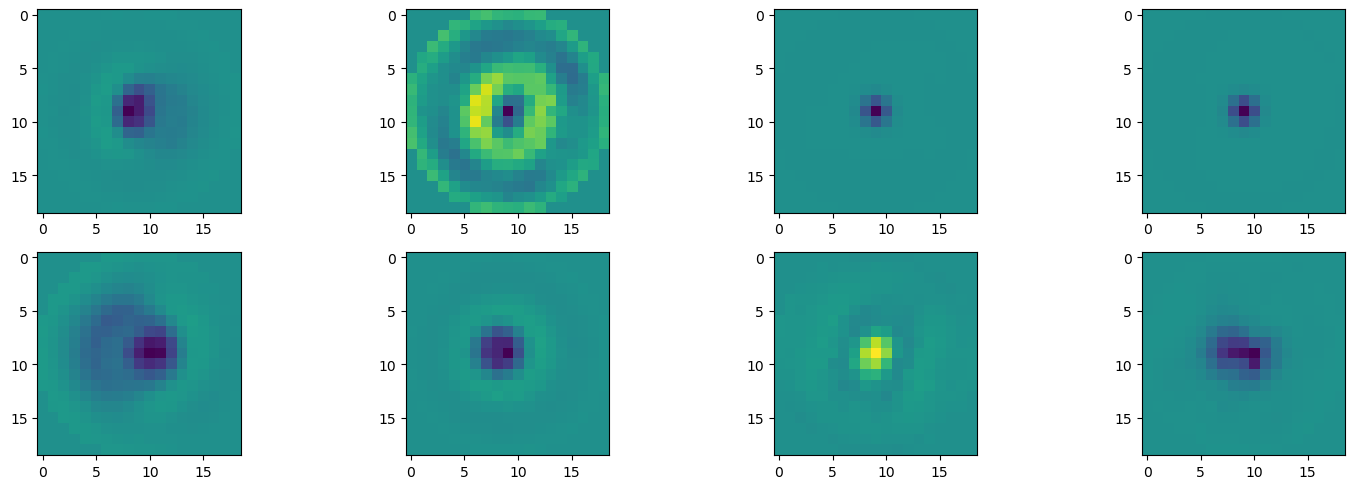

In [31]:
ss(2,4)
for i in range(8):
    plt.subplot(2,4,i+1)
    imagesc(ori_filters1[0,:,:,i])
plt.tight_layout()
plt.show()

In [32]:
ori_filters2 = cnn.get_weights(ffnet_target=0,layer_target=2)
print(ori_filters2.shape)

(8, 9, 9, 8)


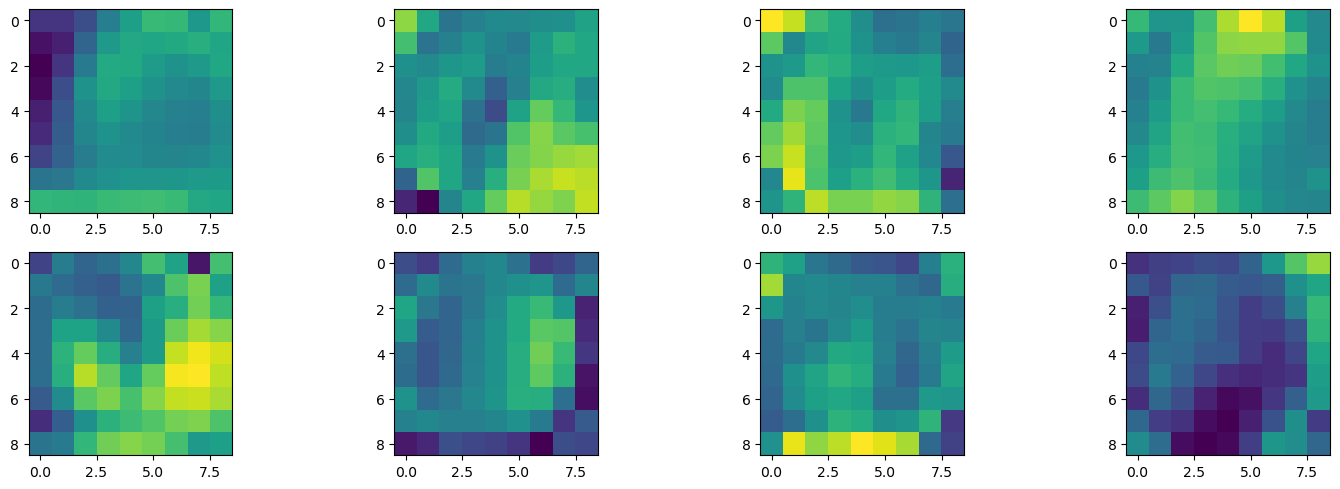

In [33]:
ss(2,4)
for i in range(8):
    plt.subplot(2,4,i+1)
    imagesc(ori_filters2[0,:,:,i])
plt.tight_layout()
plt.show()

In [34]:
sig = deepcopy(cnn.networks[1].layers[0].sigma.data).numpy()
Qsig = deepcopy(cnn.networks[1].layers[0].Qsigma.data).numpy()

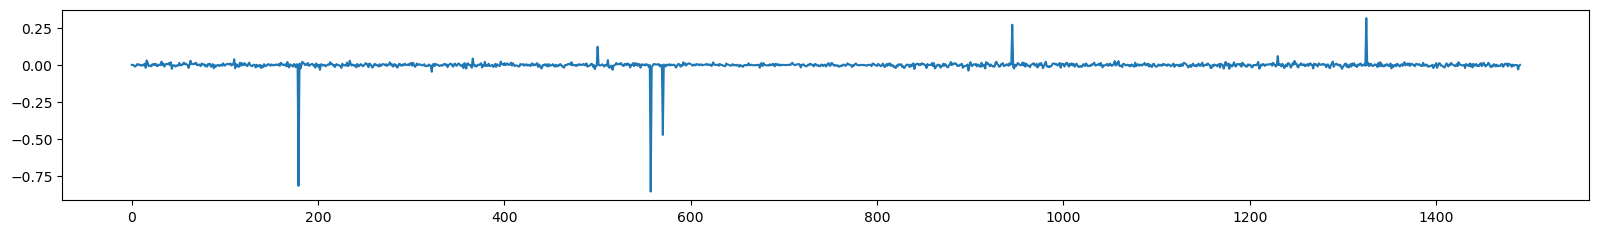

In [35]:
ss()
plt.plot(sig)

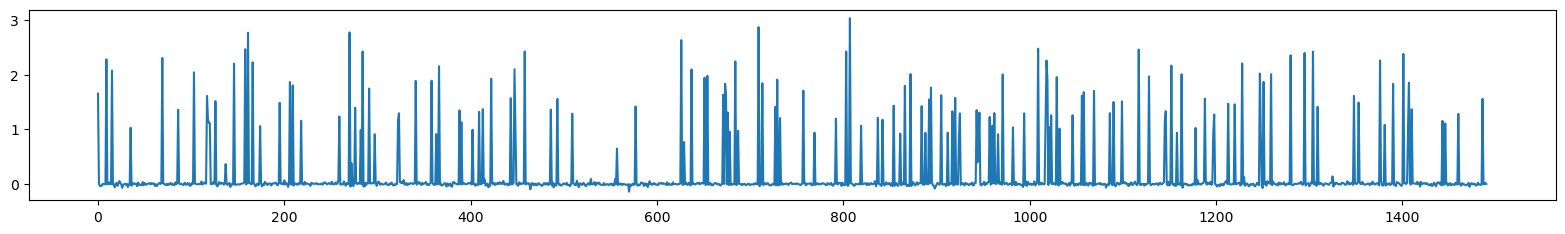

In [36]:
ss()
plt.plot(Qsig)

In [37]:
Qmu = deepcopy(cnn.networks[1].layers[0].Qmu.data).numpy()

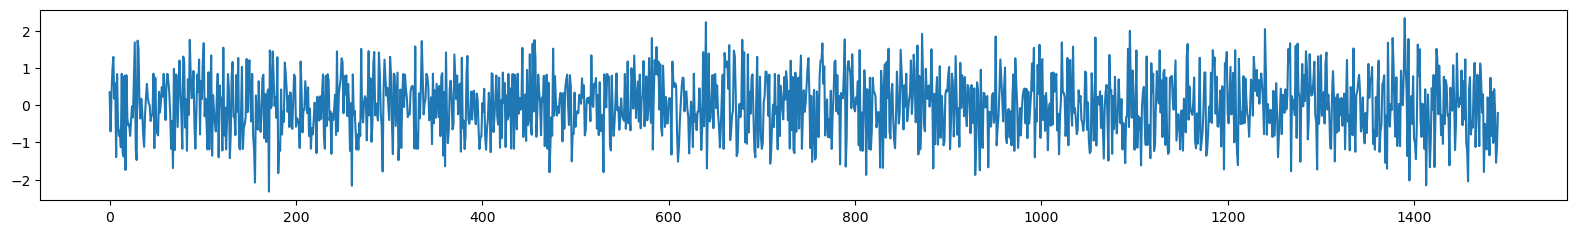

In [38]:
ss()
plt.plot(Qmu)

In [39]:
cnn_preds = cnn(data[:10]).detach().cpu().numpy()

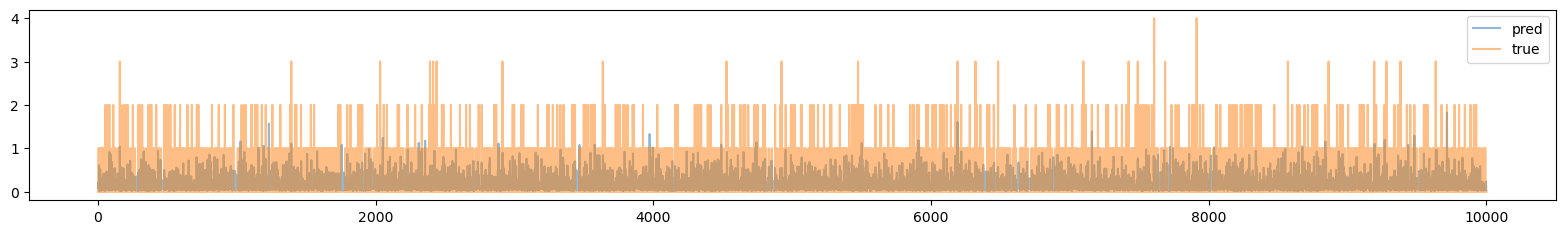

In [40]:
ss()
plt.plot(cnn_preds[:,0],label='pred',alpha=0.5)
plt.plot(data[:10]['robs'][:,0],label='true',alpha=0.5)
plt.legend()

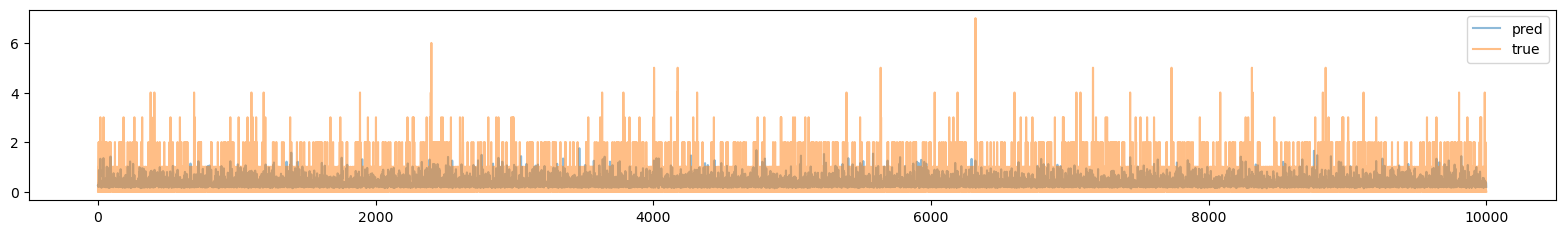

In [41]:
ss()
plt.plot(cnn_preds[:,-1],label='pred',alpha=0.5)
plt.plot(data[:10]['robs'][:,-1],label='true',alpha=0.5)
plt.legend()

## Non-Ori CNN

In [12]:
Treg = 1

# LGN layer reg
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

# Proj layer reg
Xreg1 = 0.001 # d2/dx
Creg1 = 0.001 # center 

# LGN layer
clayers = [STconvLayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=2, bias=False, norm_type=1, 
    filter_dims=[1,19,19,10], NLtype='relu', initialize_center=True,
    reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg0, 'center': Creg0} )]

# Projection Layer
clayers.append(ConvLayer.layer_dict(
    num_filters=12, num_inh=10//2,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_dims=19, NLtype='relu', reg_vals={'d2x':Xreg1, 'center': Creg1}))
    #reg_vals={'d2t':Treg, 'edge_t': 100, 'd2x':Xreg1, 'center': Creg1}))

# Time Layer w/ mask
clayers.append(MaskSTconvLayer.layer_dict(
    num_filters=20, num_inh=16//2,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_dims=[12,5,5,2], NLtype='relu', #reg_vals={'d2x':Xreg1, 'center': Creg1}))
    reg_vals={'d2t':Treg, 'edge_t': 100}))

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n='stim', layer_list=clayers, scaffold_levels=[1,2])

readout_pars = ReadoutLayer.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': 1.0})

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poisson')

mask = torch.ones(cnn.get_weights(ffnet_target=0,layer_target=2).shape, dtype=torch.float32)
mask[:,:,:,1,:] = 0
cnn.networks[0].layers[2].mask = mask.reshape(cnn.networks[0].layers[2].weight.data.shape)

cnn.networks[1].layers[0].mu.data[:,0] = torch.tensor( mu0s[:,0], dtype=torch.float32)
cnn.networks[1].layers[0].mu.data[:,1] = torch.tensor( mu0s[:,1], dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)

cnn.block_sample = True
cnn.list_parameters()

  ReadoutLayer: fitting mus
Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      weight: torch.Size([600, 20])
Network 1:
  Layer 0:
      weight: torch.Size([32, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])


In [13]:
cnn.fit(data, **adam_pars, verbose=2)

Model: M794_CsCX_R

GPU Available: True, GPU Used: True


Validating ver=31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.58it/s, val_loss=0.261838]


Early stopping
Done fitting
  Fit complete: 6101.932051420212 sec elapsed


In [14]:
cnn.save_model_zip('models/0930_three_layer_model_non-ori_CNN_L4_timemask_smallproj_0.1maxreg.ndn')

  Model saved:  models/0930_three_layer_model_non-ori_CNN_L4_timemask_smallproj_0.ndn


In [77]:
cnn = NDN.load_model_zip('models/0927_three_layer_model_non-ori_CNN_L4_timemask.ndn')
cnn.block_sample = True

In [15]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.68it/s]

Log Likelyhood shape (794,)


Mean LL: 0.46817517


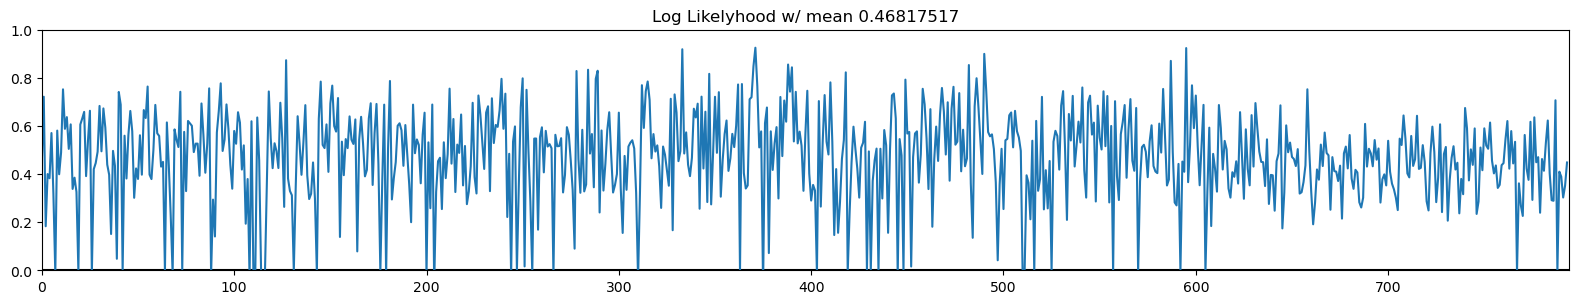

In [16]:
print('Mean LL:', np.mean(LL)) #, 'L4 Exc LL:', np.mean(LL[L4_exc_idx]), 'L4 Inh LL:', np.mean(LL[L4_inh_idx]), 
#      'L23 Exc LL:', np.mean(LL[L23_exc_idx]), 'L23 Inh LL:', np.mean(LL[L23_inh_idx]))
ss()
plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL)))
plt.xlim([0,NC])
plt.ylim([0,1])
plt.show()

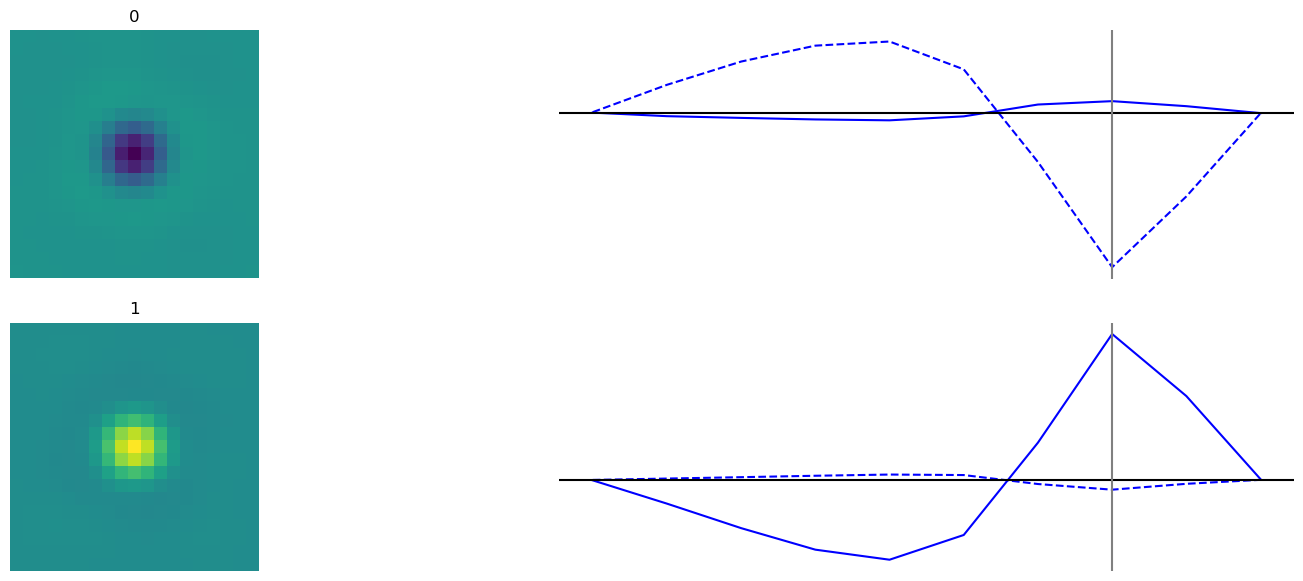

In [17]:
cnn.plot_filters()

In [18]:
filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
ei_mask_layer1 = deepcopy(cnn.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
ei_mask_layer2 = deepcopy(cnn.networks[0].layers[2]._ei_mask).detach().cpu().numpy()
print(filters1.shape)
print(ei_mask_layer1.shape)
print(ei_mask_layer2.shape)

(2, 19, 19, 12)
(12,)
(20,)


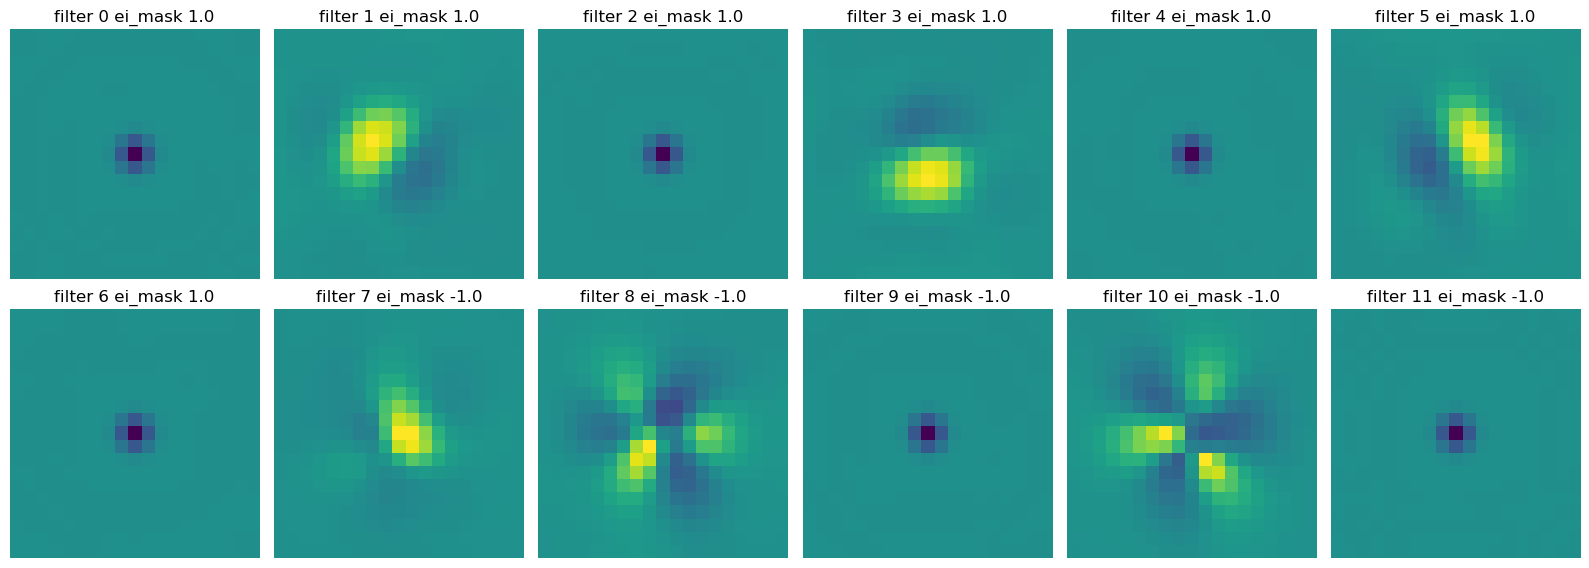

In [20]:
ss(2,6)
for i in range(12):
    plt.subplot(2,6,i+1)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
plt.tight_layout()
#plt.savefig('/home/ifernand/Desktop/filters.png')
plt.show()

In [21]:
# Readout Weights (i.e. Barcodes)
full_ei_mask = np.concatenate((ei_mask_layer1, ei_mask_layer2))
readout_w = cnn.get_weights(ffnet_target=1)
print(readout_w.shape)
print(full_ei_mask.shape)

(32, 794)
(32,)


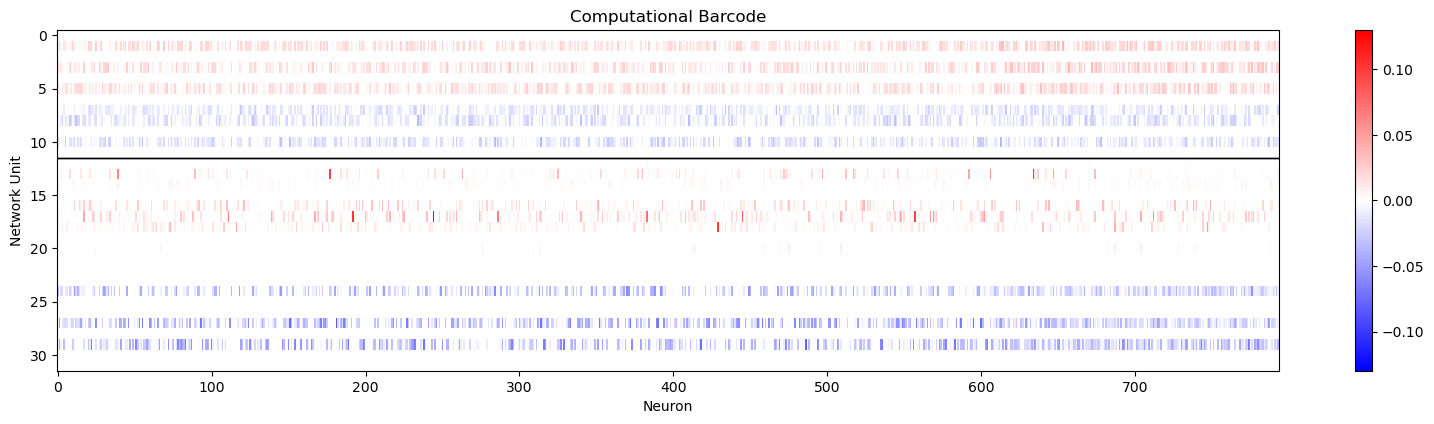

In [22]:
ss(rh=4)
imagesc((readout_w*full_ei_mask.reshape(full_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=ei_mask_layer1.shape[0]-0.5, color='black', lw=1)
plt.axhline(y=ei_mask_layer1.shape[0]-0.5, color='black', lw=1)
plt.title('Computational Barcode')
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.colorbar()

In [23]:
weight_sum = np.sum(readout_w, axis=1)/np.std(readout_w, axis=1)
print(weight_sum.shape)

(32,)


Text(0.5, 3.722222222222216, 'Network Unit')

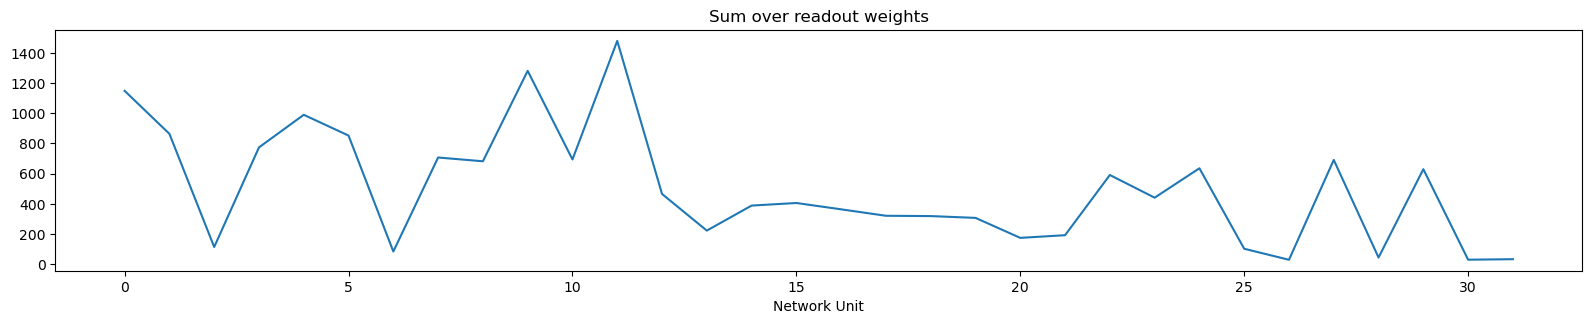

In [24]:
ss()
plt.plot(weight_sum)
plt.title('Sum over readout weights')
plt.xlabel('Network Unit')

In [25]:
filt_count = np.sum(readout_w > 0.001, axis=0)
filt_count_layer1 = np.sum(readout_w[:ei_mask_layer1.shape[0],:] > 0.001, axis=0)
filt_count_layer2 = np.sum(readout_w[ei_mask_layer1.shape[0]:,:] > 0.001, axis=0)
filt_count.shape

(794,)

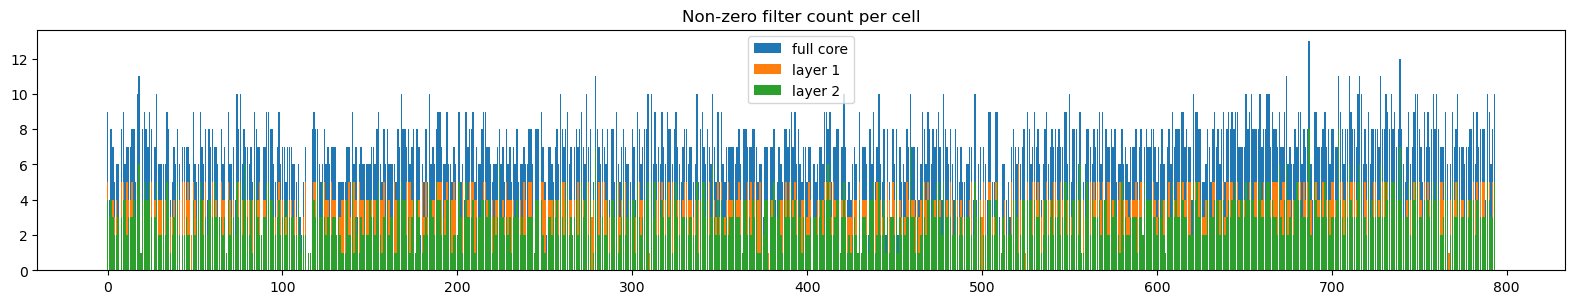

In [26]:
ss()
plt.bar(np.arange(NC),filt_count, label='full core')
plt.bar(np.arange(NC),filt_count_layer1, label='layer 1')
plt.bar(np.arange(NC),filt_count_layer2, label='layer 2')
plt.title('Non-zero filter count per cell')
plt.legend()

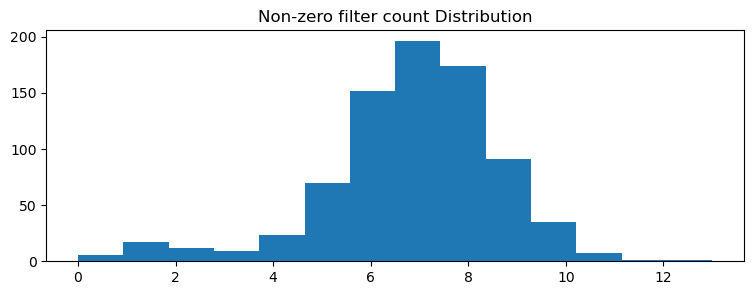

In [27]:
plt.figure(figsize=(9,3))
plt.hist(filt_count ,bins=14)
plt.title('Non-zero filter count Distribution')
plt.show()

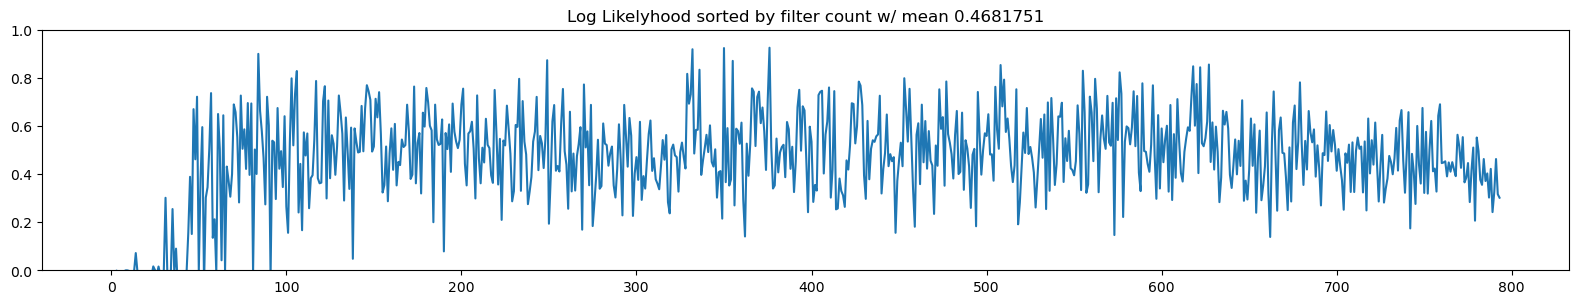

In [28]:
ss()
plt.plot(LL[np.argsort(filt_count)])
plt.title('Log Likelyhood sorted by filter count w/ mean '+str(np.mean(LL[np.argsort(filt_count)])))
plt.ylim([0,1])
plt.show()

In [29]:
filters2 = cnn.get_weights(ffnet_target=0,layer_target=2)
filters2.shape

(12, 5, 5, 2, 20)

In [30]:
weight_dist_layer2 = np.zeros((filters2.shape[-1],filters2.shape[0]))
for i in range(filters2.shape[-1]):
    weight_dist_layer2[i,:] = np.mean(filters2[:,:,:,0,i], axis=(1,2))

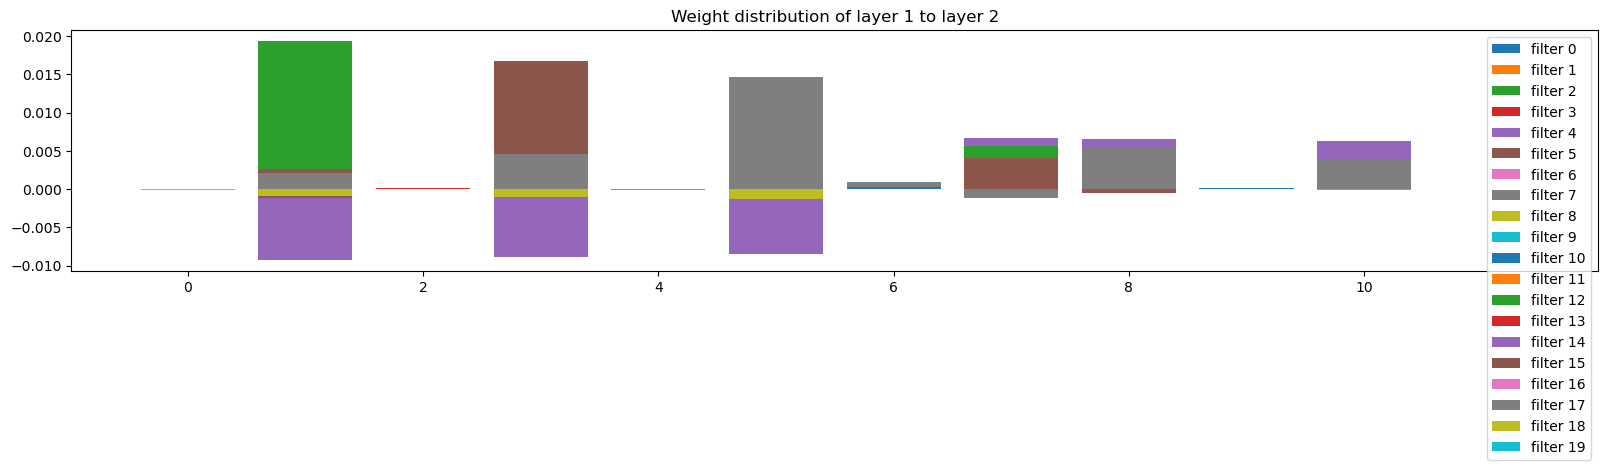

In [31]:
ss()
for i in range(filters2.shape[-1]):
    plt.bar(np.arange(filters2.shape[0]),weight_dist_layer2[i,:], label='filter '+str(i))
    plt.legend()
    plt.title("Weight distribution of layer 1 to layer 2")
    #plt.ylim([-0.02,0.02])

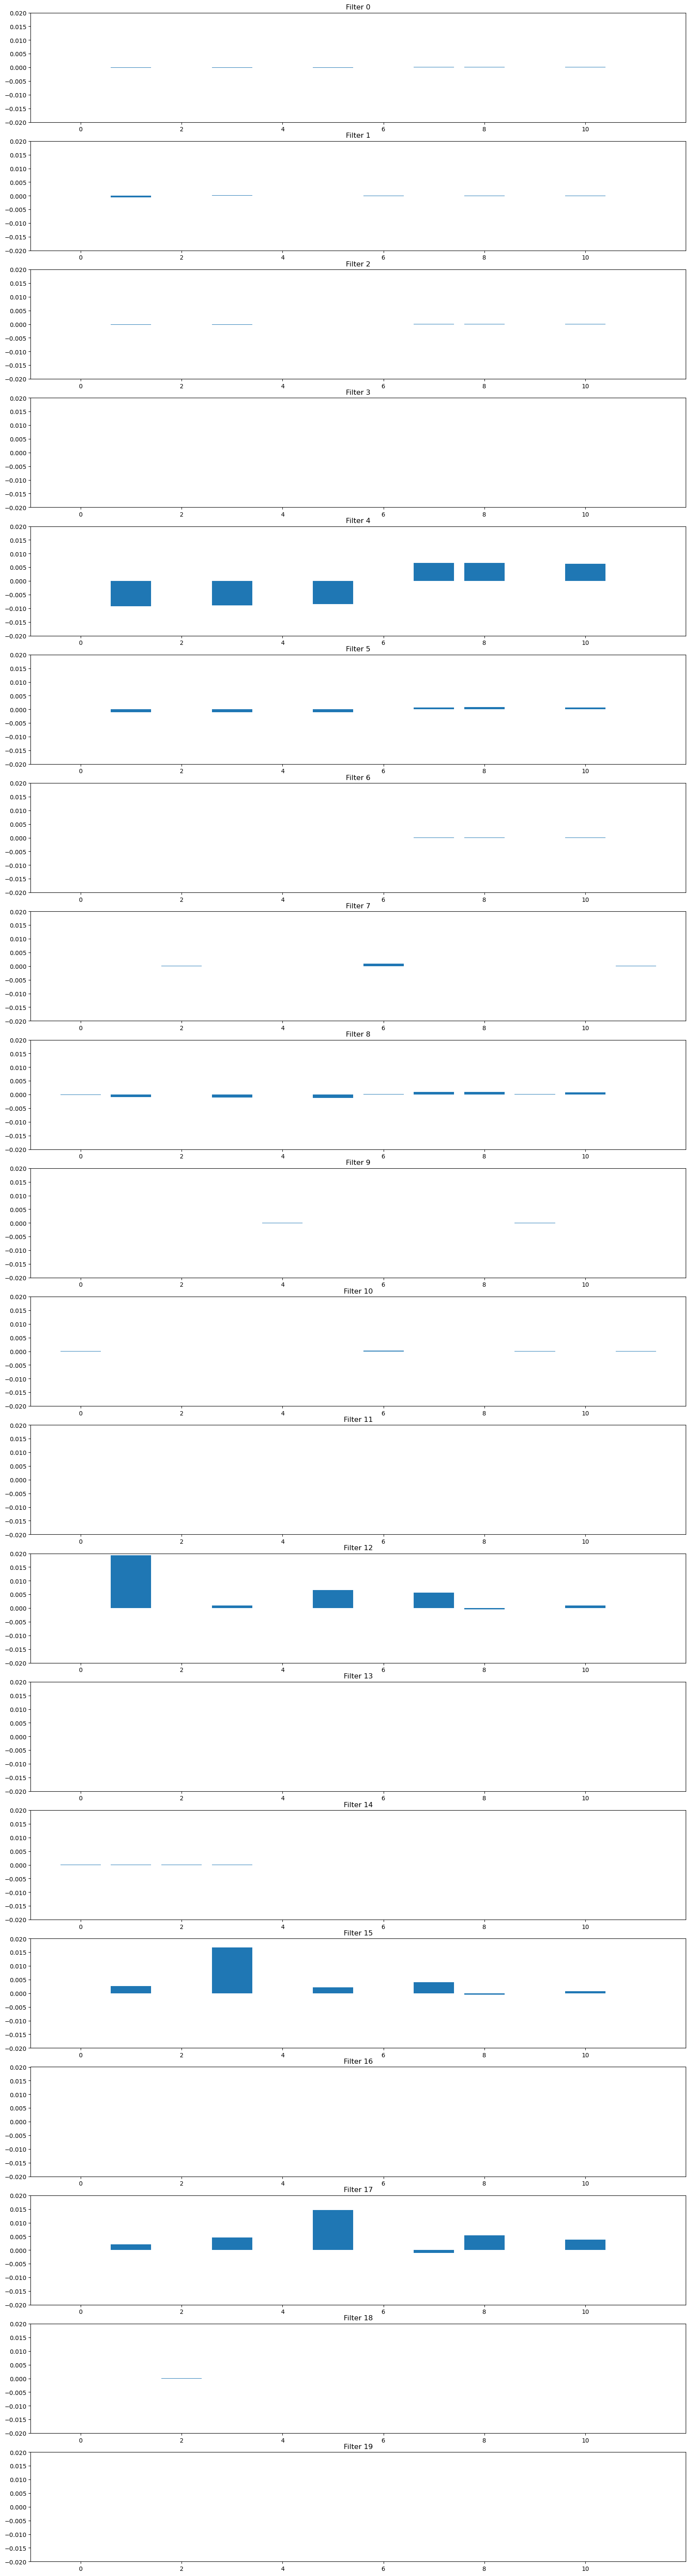

In [33]:
ss(20,1)
for i in range(filters2.shape[-1]):
    plt.subplot(20,1,i+1)
    plt.bar(np.arange(filters2.shape[0]),weight_dist_layer2[i,:])
    plt.ylim([-0.02,0.02])
    plt.title('Filter '+str(i))

In [25]:
pred = cnn.predictions(data, data_inds=data.val_blks, device=device, batch_size=3)

AssertionError: block_sample currently does not handle data_inds

## Copy network to continue training

In [40]:
cnn2 = deepcopy(cnn)

In [41]:
mask2 = torch.ones(cnn2.get_weights(ffnet_target=0,layer_target=2).shape, dtype=torch.float32)
cnn2.networks[0].layers[2].mask = mask2.reshape(cnn2.networks[0].layers[2].weight.data.shape)

In [42]:
cnn2.fit(data, **adam_pars, verbose=2)

Model: M794_CsCX_R

GPU Available: True, GPU Used: True


Validating ver=28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.42it/s, val_loss=0.254387]


Early stopping
Done fitting
  Fit complete: 1565.6103167533875 sec elapsed


In [59]:
cnn2.save_model_zip('models/0930_three_layer_model_non-ori_CNN_L4__NO_timemask_upmaxreg.ndn')

  Model saved:  models/0930_three_layer_model_non-ori_CNN_L4__NO_timemask_upmaxreg.ndn


In [43]:
LL2 = cnn2.eval_models(data, data_inds=data.val_blks, device=device, batch_size=2, null_adjusted=True)
print('Log Likelyhood shape', LL2.shape)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:07<00:00,  7.10it/s]

Log Likelyhood shape (794,)


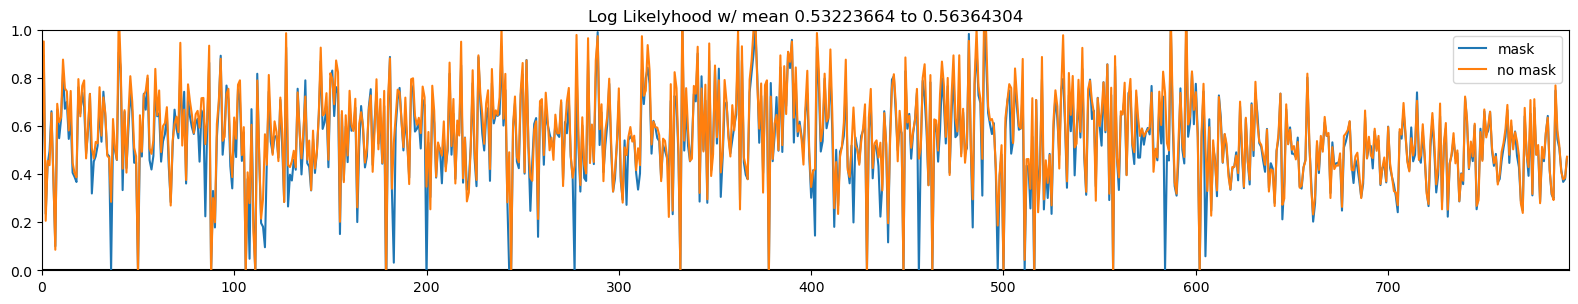

In [44]:
ss()
plt.plot([0,NC],[0,0], 'k')
plt.plot(LL, label='mask')
plt.plot(LL2, label='no mask')
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL))+' to '+str(np.mean(LL2)))
plt.xlim([0,NC])
plt.ylim([0,1])
plt.legend()
plt.show()

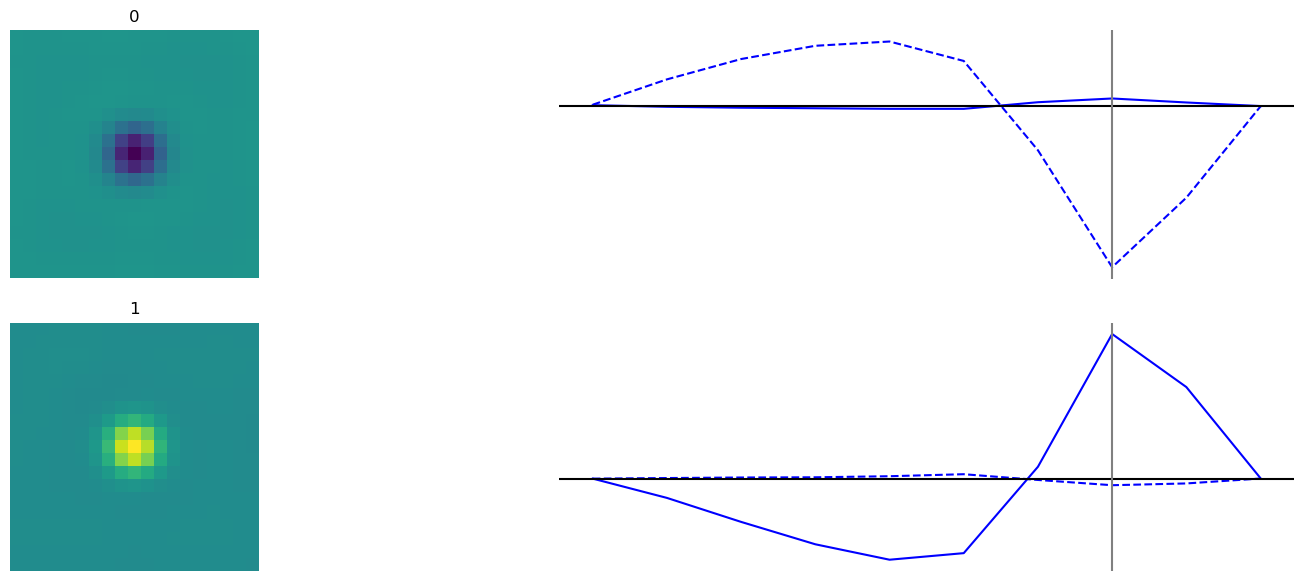

In [45]:
cnn2.plot_filters()

In [46]:
cnn2_filters1 = cnn2.get_weights(ffnet_target=0,layer_target=1)
cnn2_ei_mask_layer1 = deepcopy(cnn2.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
cnn2_ei_mask_layer2 = deepcopy(cnn2.networks[0].layers[2]._ei_mask).detach().cpu().numpy()
print(cnn2_filters1.shape)
print(cnn2_ei_mask_layer1.shape)
print(cnn2_ei_mask_layer2.shape)

(2, 19, 19, 10)
(10,)
(16,)


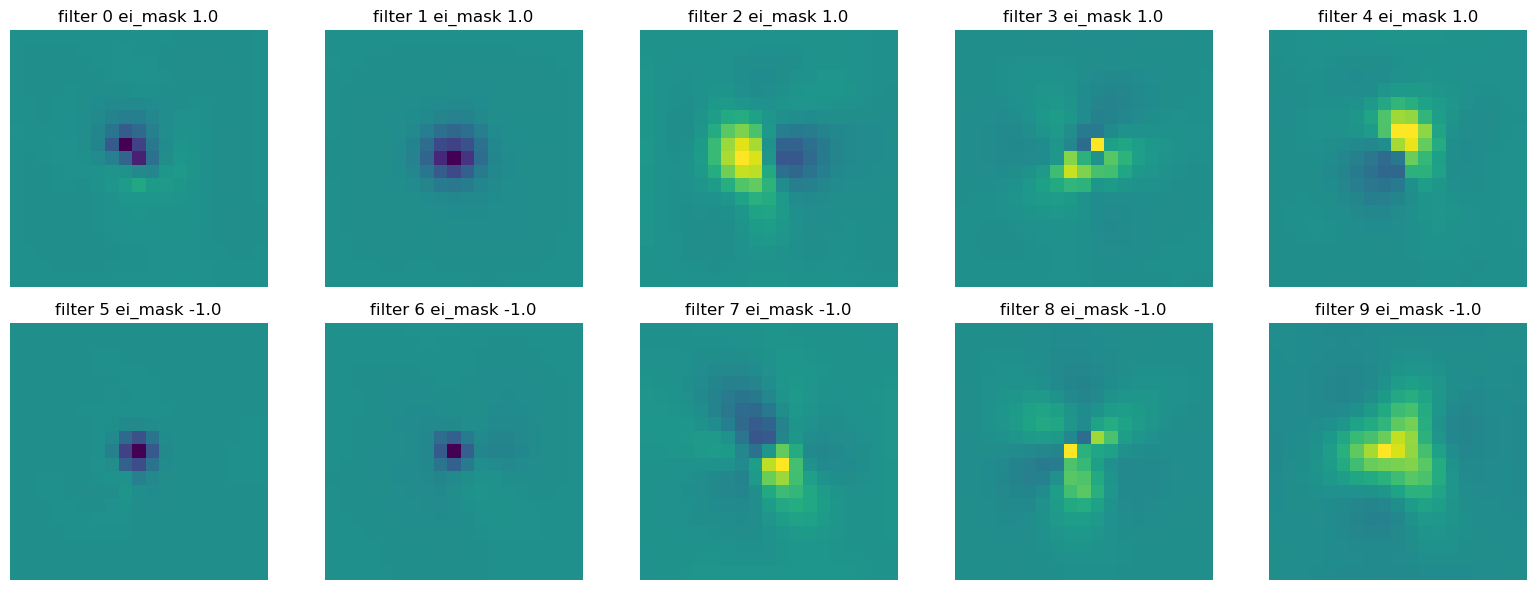

In [60]:
ss(2,5)
for i in range(10):
    plt.subplot(2,5,i+1)
    imagesc(cnn2_filters1[0,:,:,i])
    plt.title('filter '+str(i)+' ei_mask '+str(cnn2_ei_mask_layer1[i]))
    plt.axis('off')
plt.tight_layout()
#plt.savefig('/home/ifernand/Desktop/filters.png')
plt.show()

In [49]:
# Readout Weights (i.e. Barcodes)
cnn2_full_ei_mask = np.concatenate((cnn2_ei_mask_layer1, cnn2_ei_mask_layer2))
cnn2_readout_w = cnn2.get_weights(ffnet_target=1)
print(cnn2_readout_w.shape)
print(cnn2_full_ei_mask.shape)

(26, 794)
(26,)


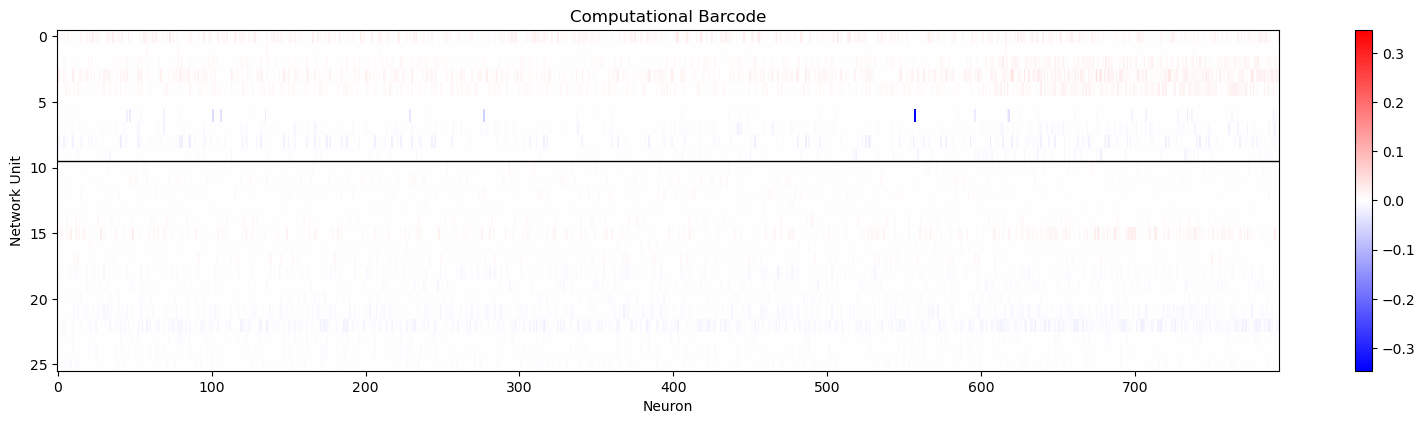

In [52]:
ss(rh=4)
imagesc((cnn2_readout_w*cnn2_full_ei_mask.reshape(cnn2_full_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=cnn2_ei_mask_layer1.shape[0]-0.5, color='black', lw=1)
plt.title('Computational Barcode')
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.colorbar()

In [53]:
cnn2_weight_sum = np.sum(cnn2_readout_w, axis=1)/np.std(cnn2_readout_w, axis=1)
print(cnn2_weight_sum.shape)

(26,)


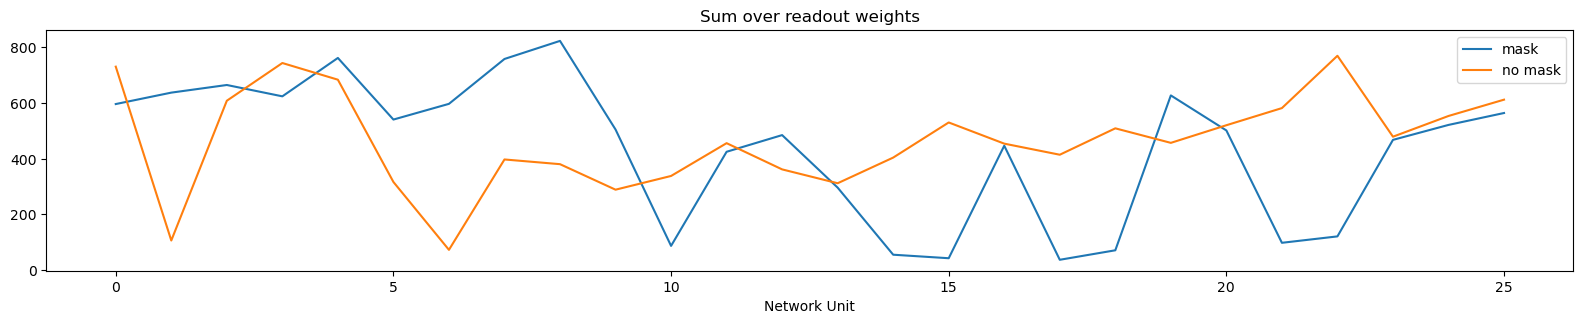

In [54]:
ss()
plt.plot(weight_sum, label='mask')
plt.plot(cnn2_weight_sum, label='no mask')
plt.title('Sum over readout weights')
plt.xlabel('Network Unit')
plt.legend()

In [55]:
cnn2_filt_count = np.sum(cnn2_readout_w > 0.001, axis=0)
cnn2_filt_count_layer1 = np.sum(cnn2_readout_w[:16,:] > 0.001, axis=0)
cnn2_filt_count_layer2 = np.sum(cnn2_readout_w[16:,:] > 0.001, axis=0)
cnn2_filt_count.shape

(794,)

<BarContainer object of 794 artists>

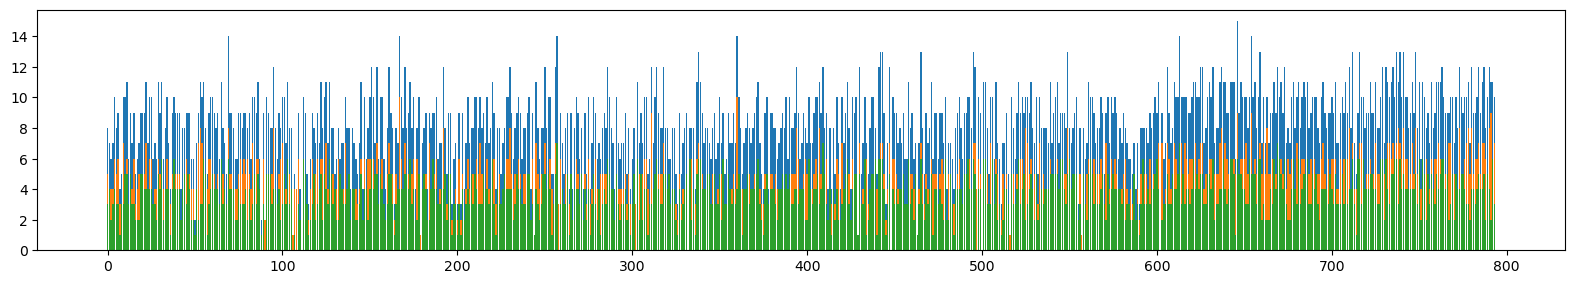

In [56]:
ss()
plt.bar(np.arange(NC),cnn2_filt_count)
plt.bar(np.arange(NC),cnn2_filt_count_layer1)
plt.bar(np.arange(NC),cnn2_filt_count_layer2)

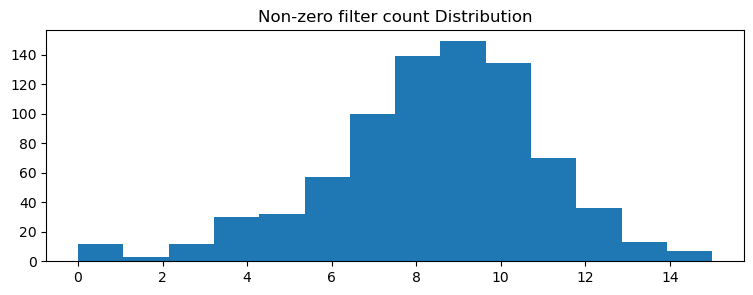

In [57]:
plt.figure(figsize=(9,3))
plt.hist(cnn2_filt_count ,bins=14)
plt.title('Non-zero filter count Distribution')
plt.show()

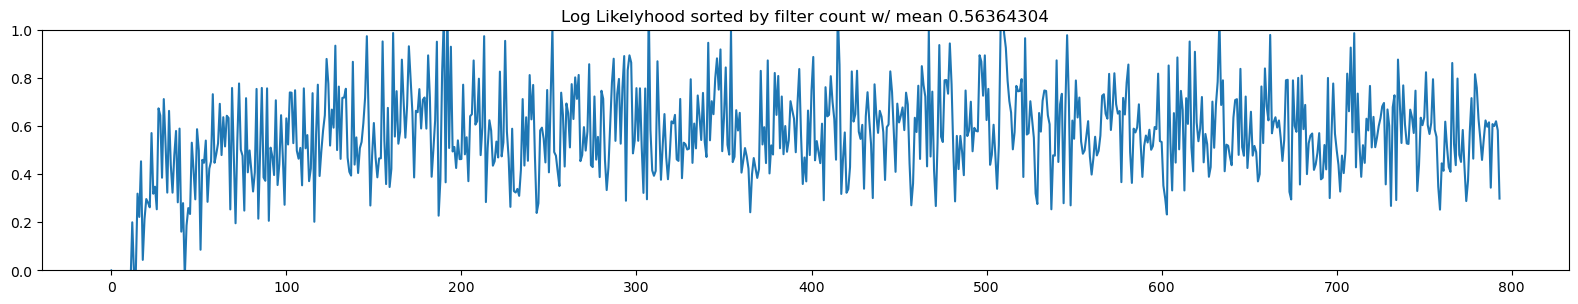

In [58]:
ss()
plt.plot(LL2[np.argsort(cnn2_filt_count)])
plt.title('Log Likelyhood sorted by filter count w/ mean '+str(np.mean(LL2[np.argsort(cnn2_filt_count)])))
plt.ylim([0,1])
plt.show()

In [62]:
cnn2_filters2 = cnn2.get_weights(ffnet_target=0,layer_target=2)
cnn2_filters2.shape

(10, 3, 3, 2, 16)

In [63]:
cnn2_weight_dist_layer2 = np.zeros((cnn2_filters2.shape[-1],cnn2_filters2.shape[0]))
for i in range(cnn2_filters2.shape[-1]):
    cnn2_weight_dist_layer2[i,:] = np.mean(cnn2_filters2[:,:,:,0,i], axis=(1,2))

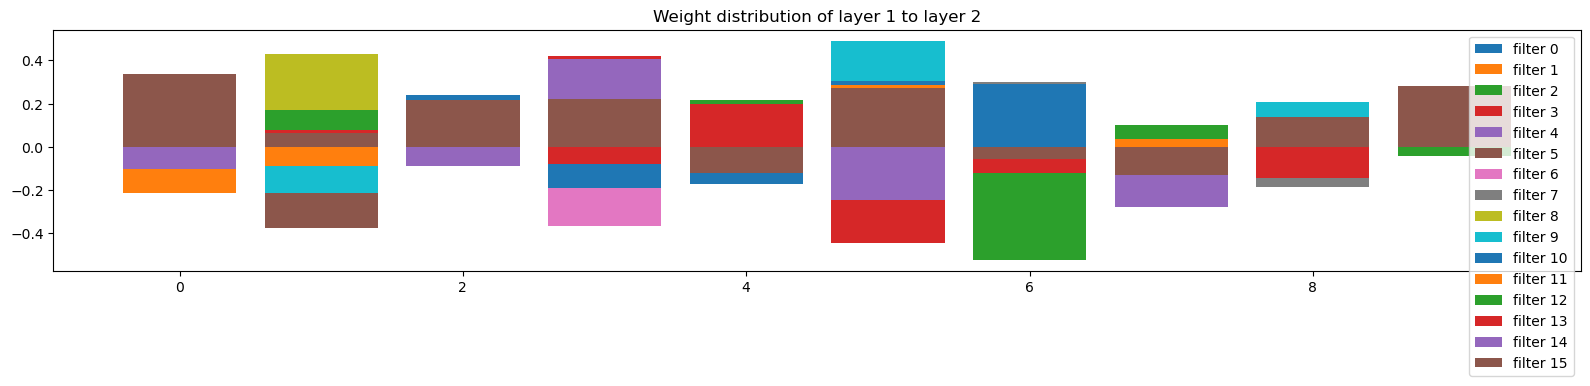

In [64]:
ss()
for i in range(cnn2_filters2.shape[-1]):
    plt.bar(np.arange(cnn2_filters2.shape[0]),cnn2_weight_dist_layer2[i,:], label='filter '+str(i))
    plt.legend()
    plt.title("Weight distribution of layer 1 to layer 2")
    #plt.ylim([-0.02,0.02])